In [3]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
#Refrence to Csv files 
cab_ride_df = pd.read_csv("Cab-Weather-Data/cab_rides.csv")
weather_df = pd.read_csv("Cab-Weather-Data/weather.csv")
 

In [5]:
# Cleaning Weather Data
# The timestamps were listed in epoch formatting, and needs to be converted to a readable date format

weather_df["date"] = pd.to_datetime(weather_df["time_stamp"], unit="s")

# Reorder the columns for readability
clean_weather_df = weather_df[["date","location","temp","clouds","pressure","rain","humidity","wind"]]


# Reset the index and change the location header to source. This is so our merge will align on common time point & weather conditions at pick up location
new_weather_df = clean_weather_df.reset_index(drop=True)
new_weather_df.rename(columns={"location":"source"}, inplace=True)
new_weather_df.head()

,date,source,temp,clouds,pressure,rain,humidity,wind
0,2018-12-16 23:45:01,Back Bay,42.42,1.0,1012.14,0.1228,0.77,11.25
1,2018-12-16 23:45:01,Beacon Hill,42.43,1.0,1012.15,0.1846,0.76,11.32
2,2018-12-16 23:45:01,Boston University,42.50,1.0,1012.15,0.1089,0.76,11.07
3,2018-12-16 23:45:01,Fenway,42.11,1.0,1012.13,0.0969,0.77,11.09
4,2018-12-16 23:45:01,Financial District,43.13,1.0,1012.14,0.1786,0.75,11.49


In [6]:
# Cleaning Car Ride Data
# The epoch timestamp in this table is represented in milliseconds, so we divide by 1000 to find the time in value of seconds
cab_ride_df["date"]=pd.to_datetime(cab_ride_df["time_stamp"]/1000, unit="s")

# Removing unwanted columns like id and product_id
clean_cab_df = cab_ride_df[["date","source","destination","distance","price","surge_multiplier","cab_type", "name"]]

# Resetting the index
new_cab_df=clean_cab_df.reset_index(drop=True)
new_cab_df.head()


,date,source,destination,distance,price,surge_multiplier,cab_type,name
0,2018-12-16 09:30:07.890000128,Haymarket Square,North Station,0.44,5.0,1.0,Lyft,Shared
1,2018-11-27 02:00:23.676999936,Haymarket Square,North Station,0.44,11.0,1.0,Lyft,Lux
2,2018-11-28 01:00:22.197999872,Haymarket Square,North Station,0.44,7.0,1.0,Lyft,Lyft
3,2018-11-30 04:53:02.749000192,Haymarket Square,North Station,0.44,26.0,1.0,Lyft,Lux Black XL
4,2018-11-29 03:49:20.223000064,Haymarket Square,North Station,0.44,9.0,1.0,Lyft,Lyft XL


In [7]:
#Merge the datesets into a single one based on time_stamp and location
cleaned_merged_df = pd.merge_asof(new_cab_df.sort_values("date"), new_weather_df.sort_values("date"), 
                            left_by=  ['source' ],right_by= ['source' ] ,
                            left_on=  ['date']   ,right_on= ['date'], tolerance=pd.Timedelta(minutes = 15 ) )
cleaned_merged_df.head()



,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,NaN,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,NaN,1.0,Uber,Taxi,40.80,0.87,1014.39,NaN,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,NaN,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,NaN,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,NaN,0.93,1.36


In [8]:
#dataframe info 
cleaned_merged_df.describe


<bound method NDFrame.describe of                                 date                   source  \
0      2018-11-26 03:40:46.318000128        Boston University   
1      2018-11-26 03:40:46.319000064         Theatre District   
2      2018-11-26 03:40:46.319000064            South Station   
3      2018-11-26 03:40:46.320000000         Theatre District   
4      2018-11-26 03:40:46.320000000  Northeastern University   
...                              ...                      ...   
693066 2018-12-18 19:15:10.943000064  Northeastern University   
693067 2018-12-18 19:15:10.943000064              Beacon Hill   
693068 2018-12-18 19:15:10.943000064  Northeastern University   
693069 2018-12-18 19:15:10.943000064  Northeastern University   
693070 2018-12-18 19:15:10.943000064  Northeastern University   

             destination  distance  price  surge_multiplier cab_type  \
0       Theatre District      3.03   34.0               1.0     Lyft   
1              North End      1.57    NaN

In [9]:
# To ensure we have all rows that have weather conditions present, we want to drop all null values in the Temperature column
# Null values for rain or wind is ok because these are logical weather conditions
final_df=cleaned_merged_df.dropna(subset=["temp"])
final_df=final_df.reset_index(drop=True)

# With the null values in other rows, we can fill them with "0"
final_df.fillna(0,inplace=True)
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36


In [10]:
#Count the numbers of temp 
final_df["temp"].count

<bound method Series.count of 0         41.07
1         40.80
2         40.86
3         40.80
4         40.81
          ...  
251822    31.20
251823    30.80
251824    30.80
251825    30.91
251826    31.20
Name: temp, Length: 251827, dtype: float64>

In [11]:
# Adding the day of the week to our table to see if that may have any correlation to weather
final_df["day_of_week"]=final_df["date"].dt.day_name()
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday


In [12]:
#Adding Month to the table 
final_df["month"] = final_df['date'].dt.month
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week,month
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday,11
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday,11
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday,11


In [13]:
# Formatting some columns to show accurate values
final_df["clouds"]=final_df["clouds"]*100
final_df["humidity"]=final_df["humidity"]*100


In [14]:
# Pretty-fying our final dataframe by including units of measurement for easy analysis

final_df = final_df.rename(columns={"date":"Date","day_of_week":"Weekday","source":"Pick_Up_Location","destination":"Destination",
                                    "distance":"Distance(m)","price":"Price($)","surge_multiplier":"Surge_Multiplier",
                                    "cab_type":"Rideshare_App","name":"Ride_Type","temp":"Temp(C)",
                                    "clouds":"Cloudiness(%)","pressure":"Pressure(MB)","rain":"Rainfall(in)",
                                    "humidity":"Humidity(%)","wind":"Wind_Speed(mph)"})

final_df = final_df[["Date","Weekday","Pick_Up_Location","Destination","Distance(m)","Price($)","Surge_Multiplier","Rideshare_App","Ride_Type",
                     "Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)"]]
final_df.head()

,Date,Weekday,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph)
0,2018-11-26 03:40:46.318000128,Monday,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36
1,2018-11-26 03:40:46.319000064,Monday,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55
2,2018-11-26 03:40:46.319000064,Monday,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60
3,2018-11-26 03:40:46.320000000,Monday,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55
4,2018-11-26 03:40:46.320000000,Monday,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36


In [15]:
# Save the dataframe into a csv file to analyze further
final_df.to_csv("rideshare_vs_weather.csv", index=False)

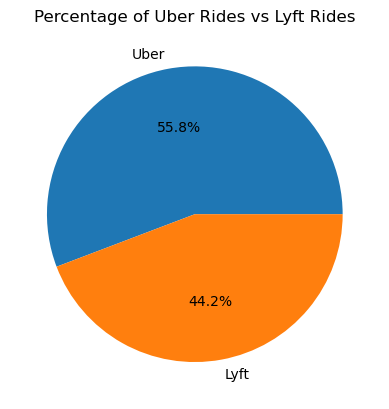

In [16]:
#Pie chart created to see the percentage of lyft rides to Uber Rides
ride_counts = final_df["Rideshare_App"].value_counts()

percentages = (ride_counts / ride_counts.sum()) * 100

plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%')
plt.title('Percentage of Uber Rides vs Lyft Rides') 
plt.show()

In [17]:
#find the min and max distance of the trips to find the ranges 

maximum_distance = final_df["Distance(m)"].max()
minimum_distance = final_df["Distance(m)"].min()

print("Maximum Distance:", maximum_distance)
print("Minimum Distance:", minimum_distance)

Maximum Distance: 7.5
Minimum Distance: 0.02


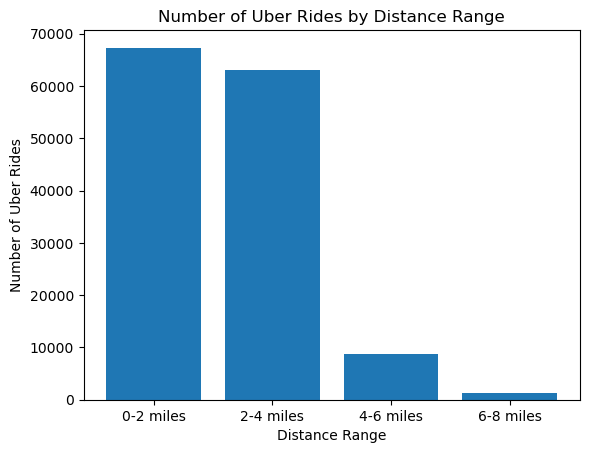

In [18]:
# Filter the DataFrame to include only Uber rides
uber_rides = final_df[final_df["Rideshare_App"] == "Uber"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((uber_rides["Distance(m)"] >= 0) & (uber_rides["Distance(m)"] <= 2)).sum(),
    ((uber_rides["Distance(m)"] > 2) & (uber_rides["Distance(m)"] <= 4)).sum(),
    ((uber_rides["Distance(m)"] > 4) & (uber_rides["Distance(m)"] <= 6)).sum(),
    ((uber_rides["Distance(m)"] > 6) & (uber_rides["Distance(m)"] <= 8)).sum()
]

# Plot the bar graph
plt.bar(distance_ranges, ride_counts)
plt.xlabel("Distance Range")
plt.ylabel("Number of Uber Rides")
plt.title("Number of Uber Rides by Distance Range")
plt.show()

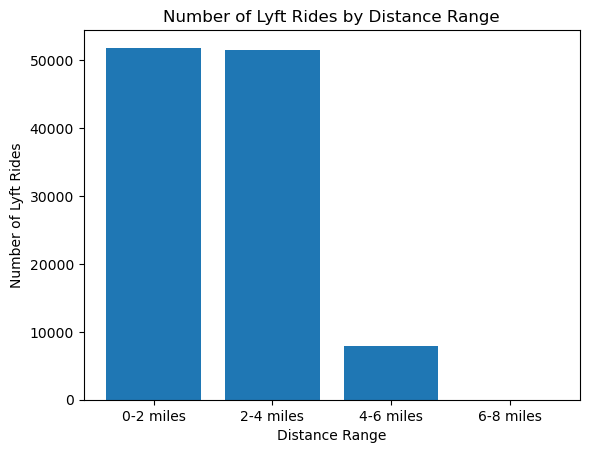

In [19]:
# Filter the DataFrame to include only Uber rides
lyft_rides = final_df[final_df["Rideshare_App"] == "Lyft"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((lyft_rides["Distance(m)"] >= 0) & (lyft_rides["Distance(m)"] <= 2)).sum(),
    ((lyft_rides["Distance(m)"] > 2) & (lyft_rides["Distance(m)"] <= 4)).sum(),
    ((lyft_rides["Distance(m)"] > 4) & (lyft_rides["Distance(m)"] <= 6)).sum(),
    ((lyft_rides["Distance(m)"] > 6) & (lyft_rides["Distance(m)"] <= 8)).sum()
]

# Plot the bar graph
plt.bar(distance_ranges, ride_counts)
plt.xlabel("Distance Range")
plt.ylabel("Number of Lyft Rides")
plt.title("Number of Lyft Rides by Distance Range")
plt.show()

In [20]:
# Total revenue for both lyft and uber
revenue_df=final_df.groupby("Rideshare_App")["Price($)"].sum()
revenue_df


Rideshare_App
Lyft    1930455.15
Uber    1902764.00
Name: Price($), dtype: float64

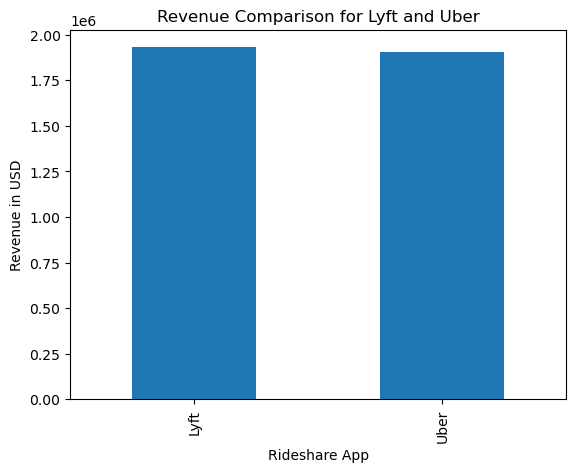

In [21]:
#Bar plot showing the revenue base on both rideshare apps
revenue_df.plot(kind='bar')
plt.title("Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

In [22]:
#Analysis on how rain can effect the cab rides
rain_analysis = final_df[['Pick_Up_Location', 'Date', 'Rideshare_App',  "Rainfall(in)"]]

In [23]:
rain_analysis.isnull().sum()

Pick_Up_Location    0
Date                0
Rideshare_App       0
Rainfall(in)        0
dtype: int64

In [24]:
#Set the null values if there are any in the data set as 0 and consider it as no rainfall. 
rain_analysis["Rainfall(in)"].fillna(value=0)

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
251822    0.0
251823    0.0
251824    0.0
251825    0.0
251826    0.0
Name: Rainfall(in), Length: 251827, dtype: float64

In [25]:
#check count of no rain fall vs rainfall days 
count_rain = rain_analysis.groupby(["Rainfall(in)"]).size().reset_index()
count_rain.columns=["Rainfall(in)", "count"]
print(count_rain)

     Rainfall(in)   count
0          0.0000  210883
1          0.0002      77
2          0.0003     126
3          0.0005      11
4          0.0006      37
..            ...     ...
418        0.7247      40
419        0.7505      71
420        0.7625      49
421        0.7753      61
422        0.7807      76

[423 rows x 2 columns]


<Axes: xlabel='Rainfall(in)', ylabel='count'>

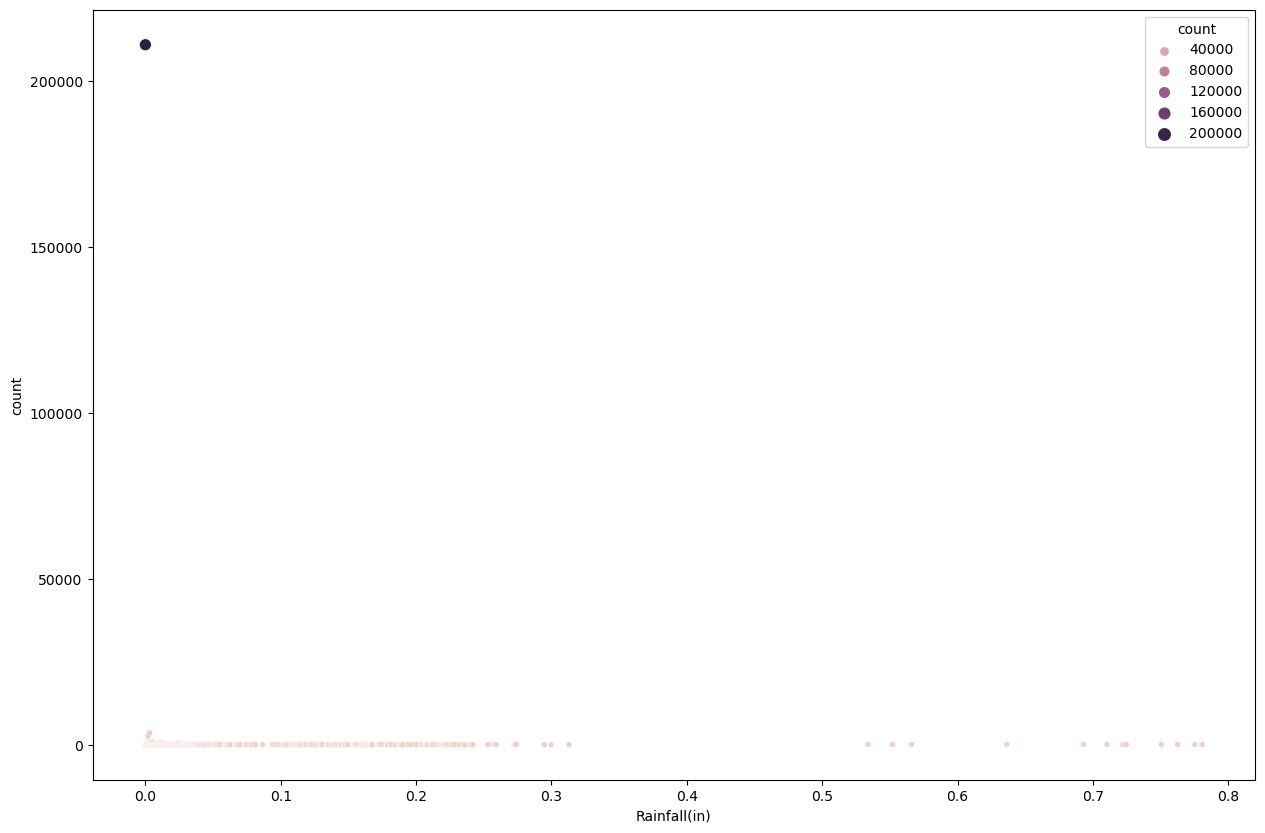

In [26]:
#Scatter plot to show number of rides when it rains vs no rain
plt.figure(figsize=(15, 10))
sns.scatterplot(data = count_rain, x = "Rainfall(in)", y="count", hue="count", size="count")

In [27]:
rain_analysis.head()


,Pick_Up_Location,Date,Rideshare_App,Rainfall(in)
0,Boston University,2018-11-26 03:40:46.318000128,Lyft,0.0
1,Theatre District,2018-11-26 03:40:46.319000064,Uber,0.0
2,South Station,2018-11-26 03:40:46.319000064,Uber,0.0
3,Theatre District,2018-11-26 03:40:46.320000000,Uber,0.0
4,Northeastern University,2018-11-26 03:40:46.320000000,Lyft,0.0


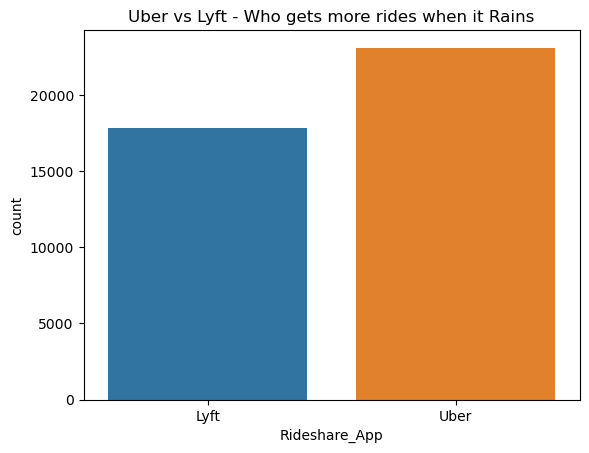

In [28]:
#Check on which company gets more rides when it rains. As per below analysis it looks like Uber gets more rides when it rains, but if we had more data then this gap would have reduced.
Rain = rain_analysis[rain_analysis["Rainfall(in)"]!= 0]
count_Rainfall = Rain.groupby(["Rideshare_App"]).size().reset_index()
count_Rainfall.columns = ["Rideshare_App","count"]
sns.barplot(x ="Rideshare_App", y="count", data=count_Rainfall).set_title("Uber vs Lyft - Who gets more rides when it Rains");

[Text(0.5, 0, 'Cab Type'), Text(0, 0.5, 'Number of cab')]

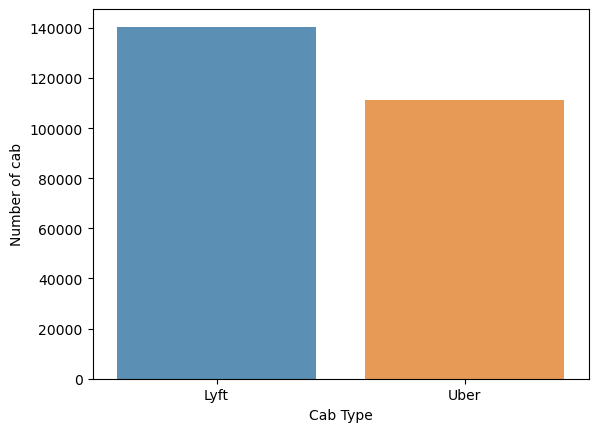

In [29]:
#Analysis to find Price vs distcance chart
# Explanation - Used Pie chart to find who gets more rides. 
# Explantion - Used Scatter plot to show general price vs distance chart, I dropped taxi from the data set as it contains 0 value for Uber cabs.
#based on the color combinations I want to figure out who has lower minimum fare based on the distance covered. 
Count = [final_df.Rideshare_App[(final_df.Rideshare_App)=='Uber'].count(),\
     final_df.Rideshare_App[(final_df.Rideshare_App)=='Lyft'].count()]
vis1= sns.barplot(x=final_df["Rideshare_App"].unique(), y=Count, alpha=0.8)
vis1.set(xlabel='Cab Type',ylabel='Number of cab')

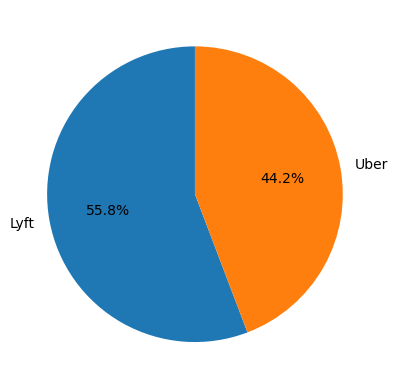

In [30]:
#Pie Chart
for p in vis1.patches:
             vis1.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
        
        
Ncab_type = [final_df.Rideshare_App[(final_df.Rideshare_App)=='Uber'].count(),\
             final_df.Rideshare_App[(final_df.Rideshare_App)=='Lyft'].count()]

plt.pie(Ncab_type, labels=final_df["Rideshare_App"].unique(), startangle=90, autopct='%.1f%%')

plt.show()

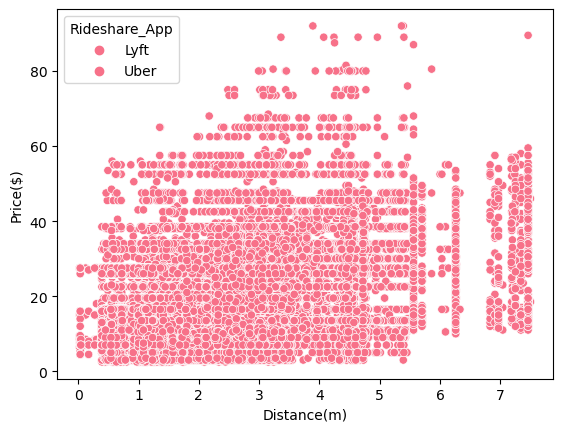

In [31]:
# Scatter Plot
Taxi=final_df[final_df.Ride_Type == 'Taxi'].index
final_df.drop(Taxi , inplace=True)
vis1 = sns.scatterplot(x=final_df["Distance(m)"], y=final_df["Price($)"], data=final_df, hue=final_df["Rideshare_App"], hue_order=final_df["Rideshare_App"], alpha= 1, legend='full')


In [32]:
#Analysis on Surge Multiplier - For LYFT 
Surge_Lyft=final_df[final_df.Rideshare_App == 'Lyft']
Surge_Uber=final_df[final_df.Rideshare_App == 'Uber']
uber_df = final_df[final_df["Ride_Type"] == "Uber"]
lyft_df = final_df[final_df["Ride_Type"] == "Lyft"]
lyft_df["Surge_Multiplier"].value_counts()

1.00    17026
1.25      784
1.50      367
1.75      169
2.00      155
2.50       30
3.00        3
Name: Surge_Multiplier, dtype: int64

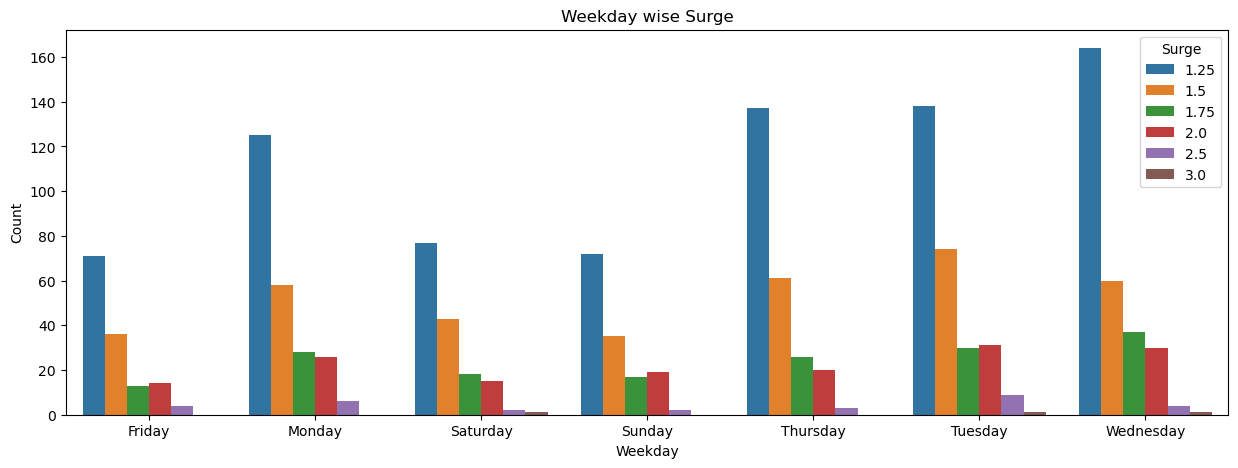

In [33]:
#considering only Surge that is greater than 1
#Explanation- Surge is observed mostly on Wednesday.3.0 surge is very less occuring surge. 
high_surge_dataset = lyft_df[lyft_df["Surge_Multiplier"]> 1]
t_high_surge = pd.DataFrame(high_surge_dataset.groupby(["Weekday", "Surge_Multiplier"]).size().reset_index())
t_high_surge.columns = ["Weekday", "Surge", "Count"]
plt.figure(figsize=(15, 5))
sns.barplot(x="Weekday", y="Count", hue="Surge", data=t_high_surge).set_title("Weekday wise Surge");

C:\Users\pratik.deshmane\AppData\Local\Temp\ipykernel_19412\669265665.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Monday'],label = 'Monday', data=final_df, ci=None);
C:\Users\pratik.deshmane\AppData\Local\Temp\ipykernel_19412\669265665.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Tuesday'],label = 'Tuesday', data=final_df, ci=None);
C:\Users\pratik.deshmane\AppData\Local\Temp\ipykernel_19412\669265665.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Wednesday'],label = 'Wednesday', data=final_df, ci=None);
C:\Users\pratik.deshmane\AppData\Local\Temp\ipyker

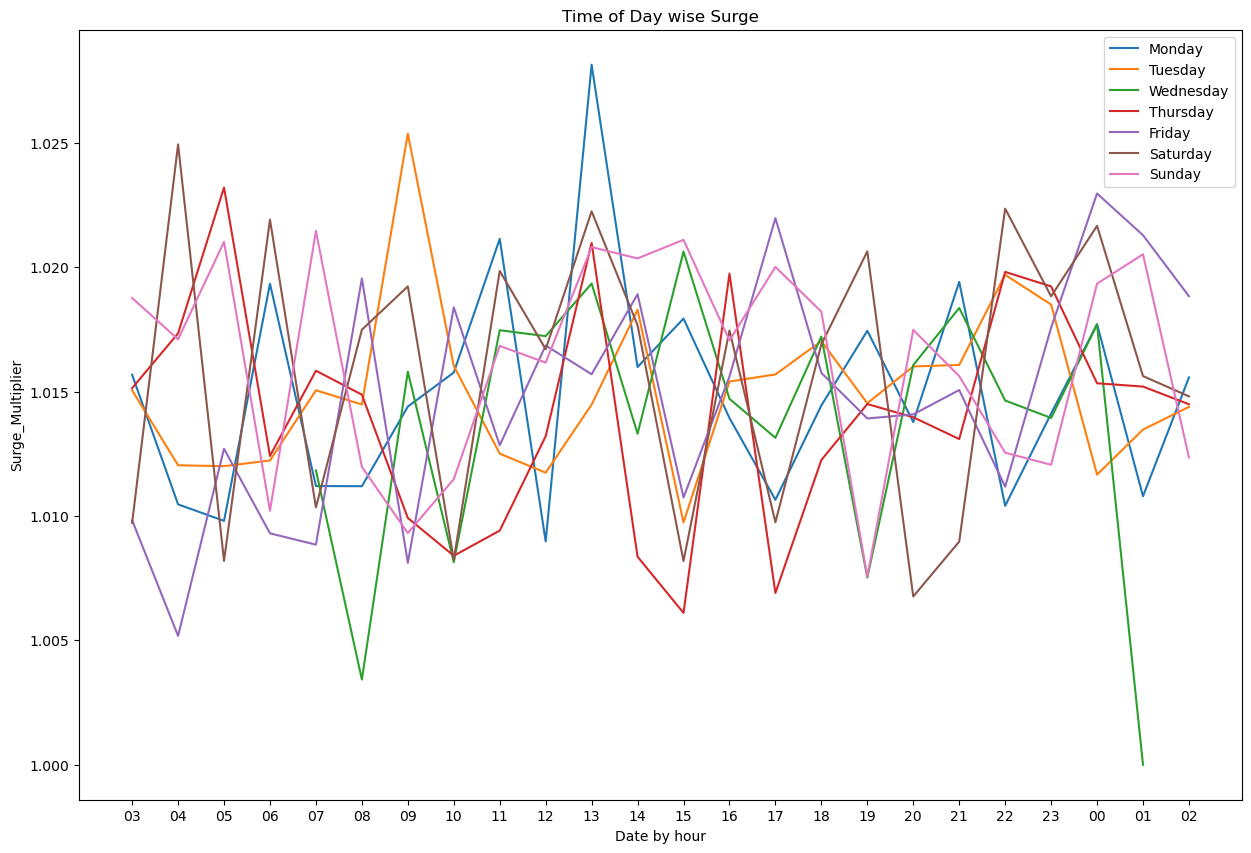

In [34]:
# Time of the day Surge 
df = pd.DataFrame({'date': pd.date_range('2018-07-02 10:54:00', periods=5)})
final_df['Day'] = pd.to_datetime(final_df['Date']).dt.date
#final_df['Time'] = pd.to_datetime(final_df['Date']).dt.time
final_df["Date by hour"]=final_df["Date"].dt.strftime("%H")
#print(final_df)
td_high_surge = pd.DataFrame(final_df.groupby(["Weekday", "Surge_Multiplier","Date by hour"]).size().reset_index())
td_high_surge.columns = ["Weekday", "Surge", "Date by hour", "Count"]
plt.figure(figsize=(15, 10))
#[final_df.Rideshare_App[(final_df.Rideshare_App)=='Uber'],
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Monday'],label = 'Monday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Tuesday'],label = 'Tuesday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Wednesday'],label = 'Wednesday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Thursday'],label = 'Thursday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Friday'],label = 'Friday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Saturday'],label = 'Saturday', data=final_df, ci=None);
sns.lineplot(x=final_df["Date by hour"],y= final_df.Surge_Multiplier[(final_df.Weekday)=='Sunday'],label = 'Sunday', data=final_df, ci=None).set_title("Time of Day wise Surge");


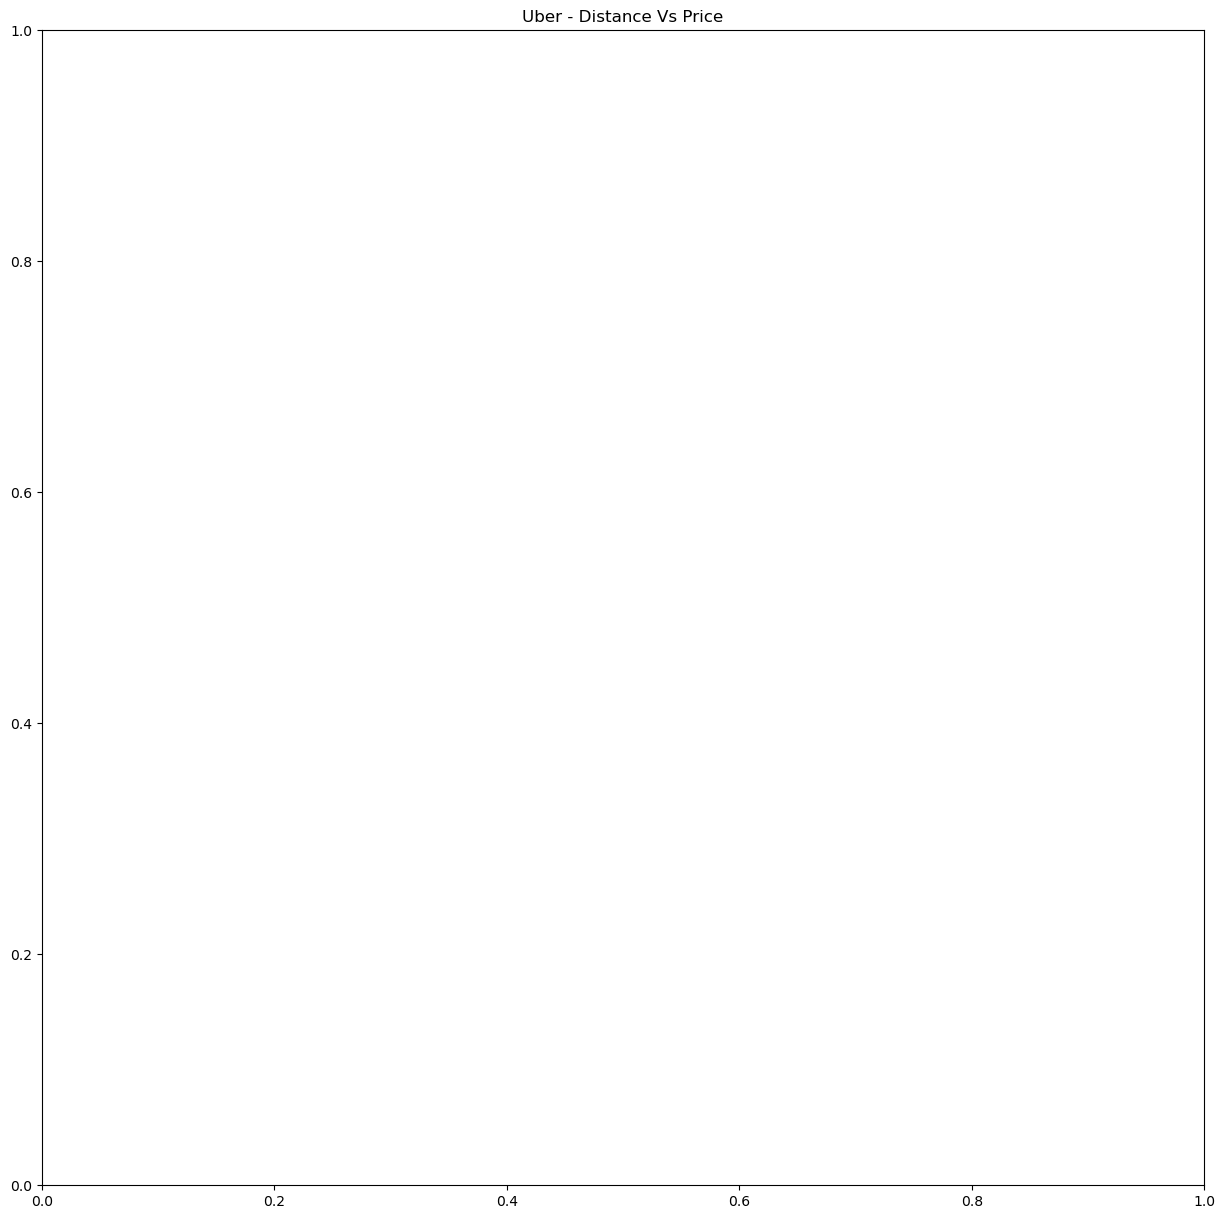

In [35]:
#Distance vs surge
uber_dis_price_surge = uber_df[['Distance(m)', 'Surge_Multiplier', 'Price($)']]
lyft_dis_price_surge = lyft_df[['Distance(m)', 'Surge_Multiplier', 'Price($)']]
plt.figure(figsize=(15, 15))
sns.scatterplot(data=uber_dis_price_surge, x="Distance(m)", y="Price($)", hue="Surge_Multiplier").set_title("Uber - Distance Vs Price");


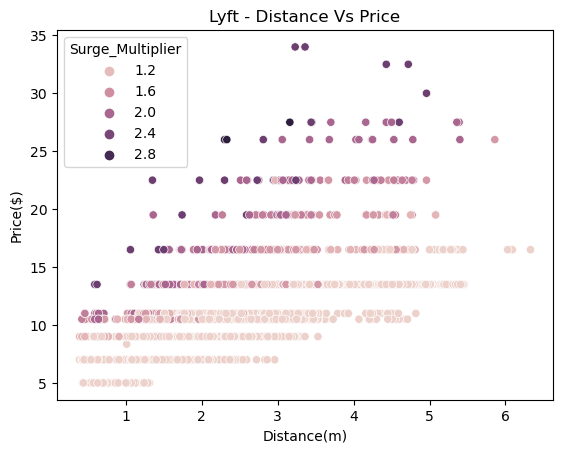

In [36]:
sns.scatterplot(data=lyft_dis_price_surge, x="Distance(m)", y="Price($)", hue="Surge_Multiplier").set_title("Lyft - Distance Vs Price");
#Distance and price doenst seems to be corelated with reference to sruge multiplier, Even Higher Distance sometimes has low surge multiplier.

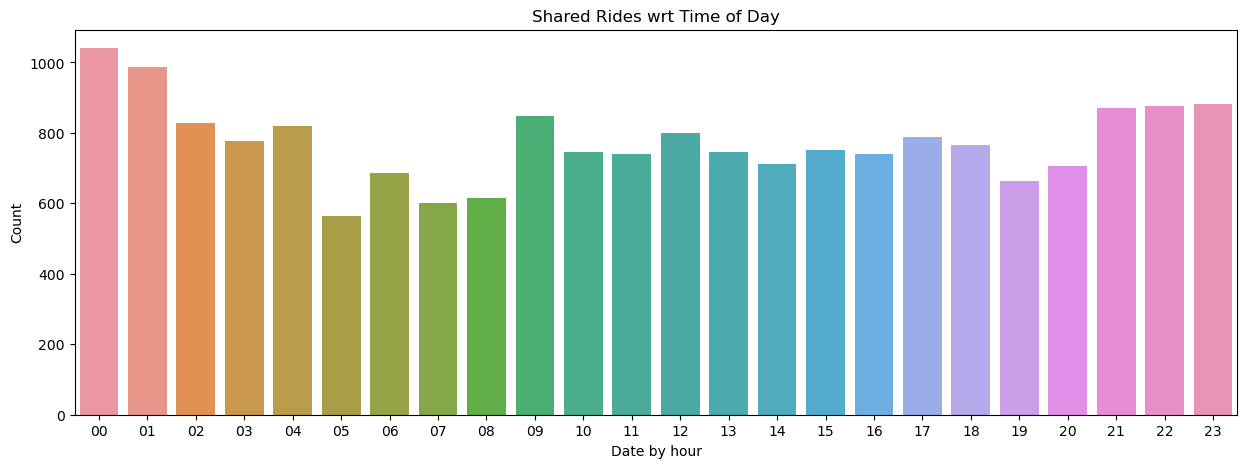

In [67]:
#Analysis on Shared rides with respect to time of the day.
final_df["Ride_Type"].value_counts()
lyft_shared_rides_df = final_df[final_df["Ride_Type"] == "Shared"]
lyft_shared_ride_td = lyft_shared_rides_df.groupby(["Ride_Type", "Date by hour"]).size().reset_index()
lyft_shared_ride_td.columns = ["Ride_Type", "Date by hour", "Count"]
plt.figure(figsize=(15, 5))
sns.barplot(x="Date by hour", y="Count", data = lyft_shared_ride_td).set_title("Shared Rides wrt Time of Day");
#sns.barplot(x=final_df["Rideshare_App"].unique(), y=Count, alpha=0.8)


In [63]:
print(lyft_shared_ride_td["Date by hour"])

0     00
1     01
2     02
3     03
4     04
5     05
6     06
7     07
8     08
9     09
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
Name: Date by hour, dtype: object
